# Build an LSTM-based Stock Price Predictor

1. Train an LSTM model for stock price forecasting.
2. Compare its performance with the basic RNN.
3. Visualize predictions over time.

We'll use real stock market data to train our LSTM model.

## Step 1 - Get the data

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


what is yf?
yfinance is a popular, open-source Python library that allows users to access and download financial data from Yahoo Finance. It's developed by Ran Aroussi and provides access to a wide range of data, including stock quotes, options, and fundamental financials

In [2]:
# Download AAPL stock data for the past 5 years
stock_data = yf.download(['AAPL'], start='2019-01-01', end='2024-01-01')

# Display first few rows
print(stock_data.head())


C:\Users\ompan\AppData\Local\Temp\ipykernel_1920\3581256665.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(['AAPL'], start='2019-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2019-01-02  37.575214  37.796499  36.697222  36.854262  148158800
2019-01-03  33.832455  34.672377  33.787246  34.258363  365248800
2019-01-04  35.276730  35.345734  34.215527  34.389221  234428400
2019-01-07  35.198208  35.412354  34.715193  35.381421  219111200
2019-01-08  35.869186  36.123782  35.338585  35.586039  164101200


In [3]:
stock_data.shape

(1258, 5)

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1258 non-null   float64
 1   (High, AAPL)    1258 non-null   float64
 2   (Low, AAPL)     1258 non-null   float64
 3   (Open, AAPL)    1258 non-null   float64
 4   (Volume, AAPL)  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


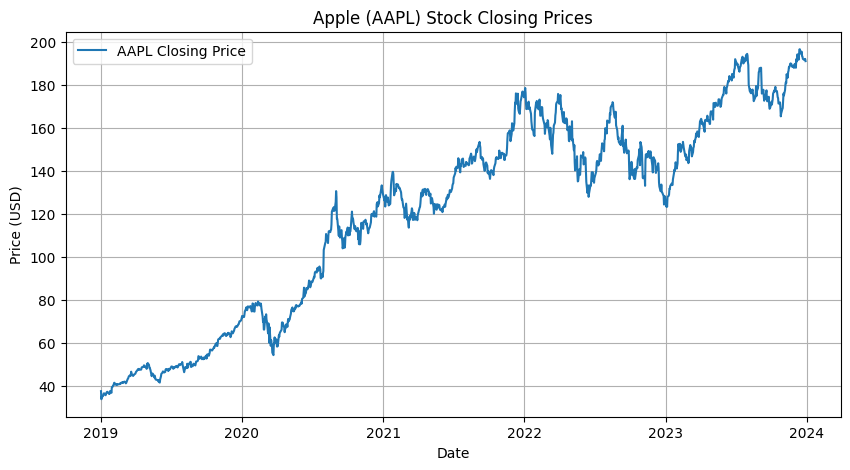

In [5]:
plt.figure(figsize=(10,5))
plt.plot(stock_data['Close'], label="AAPL Closing Price")
plt.title("Apple (AAPL) Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


## Step 2: Data Preprocessing

We need to:
1. Extract Closing Prices – Use only the 'Close' column.
2. Normalize Data – Scale values between 0 and 1 for better LSTM performance.
3. Create Sequences – Convert the data into time-series windows for LSTM.
4. Split into Training & Testing Sets – Use 80% for training, 20% for testing.



### Extract Closing Prices – Use only the 'Close' column.

We only use the 'Close' price because it represents the final traded price of Apple stock each day, making it a good indicator of trends.
Other columns like Open, High, and Low may add noise unless we specifically design a multi-feature model.
The extracted data is stored in a NumPy array for easier manipulation.

In [6]:
data = stock_data[['Close']].values

In [7]:
print(type(data), data.shape)

<class 'numpy.ndarray'> (1258, 1)


### Normalize Data – Scale values between 0 and 1 for better LSTM performance.

Stock prices have large variations (e.g., AAPL ranged from $30 to $180 over 5 years).
LSTMs work better when input values are scaled between 0 and 1 to improve training stability.
Min-Max Scaling helps prevent issues like exploding gradients and speeds up learning.

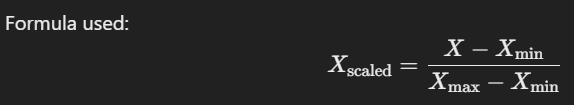

This transformation ensures that all values lie within the same range, making the model more stable.



In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

### Create Sequences – Convert the data into time-series windows for LSTM.

Unlike traditional ML models, LSTMs need sequential time-series input to learn patterns.
We convert raw stock prices into sequences where:

Input (X): Last 60 days of prices

Output (y): The next day's price

This helps the LSTM learn dependencies between past prices and future prices.
Example:

If X = [Day 1, Day 2, ..., Day 60]

Then y = [Day 61] (price we want to predict)

This step is critical because LSTMs specialize in learning patterns across sequences.

In [9]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Use 30/60 days of past data to predict the next day's price
time_steps = 30
X, y = create_sequences(data_scaled, time_steps)

In [10]:
X.shape

(1228, 30, 1)

In [11]:
y.shape

(1228, 1)

### Split into Training & Testing Sets – Use 80% for training, 20% for testing.

We split the data 80-20 to train and evaluate the model properly.
The first 80% is used for training, allowing the model to learn historical patterns.
The last 20% is for testing, ensuring the model can generalize to unseen data.
This ensures that our model is evaluated on future stock prices, simulating a real-world scenario.

In [12]:
split = int(len(X) * 0.8)  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Step 3: Build the LSTM Model

Model Architecture
* LSTM Layers – Capture patterns in sequential stock prices.
* Dropout Layer – Prevent overfitting.
* Dense Layer – Predict the next stock price.
* Adam Optimizer – Adjusts learning rate dynamically.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM Model
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], 1)),
    LSTM(units=100, return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(units=50, return_sequences=False),  # Second LSTM layer
    Dense(units=1)  # Output layer (predicts next stock price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the model

In [14]:

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0276 - val_loss: 0.0107
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 8.3163e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss:

## Step 5: Make Predictions & Evaluate Performance

In [15]:
# Predict stock prices on test data
predicted_prices = model.predict(X_test)

# Convert predictions back to original scale
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [16]:
len(stock_data.index[split+time_steps:])

246

In [17]:
len(y_test)

246

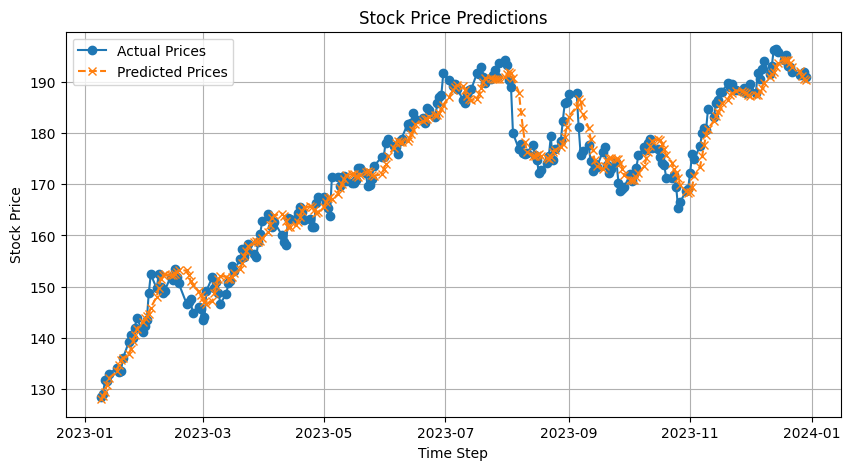

In [18]:
plt.figure(figsize=(10,5))
plt.plot(stock_data.index[split+time_steps:], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual Prices", marker="o")
plt.plot(stock_data.index[split+time_steps:], predicted_prices, label="Predicted Prices", linestyle="dashed", marker="x")
plt.title("Stock Price Predictions")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()